# Section B. Prediction Uncertainty with Bootstrapping

## Bootstrapping

In [1]:
#importing the libraries
options(warn=-1)
library(reshape2)
library(ggplot2)
library(corrplot)

corrplot 0.84 loaded


In [2]:
#Loading the dataset
train.data.csv<-read.csv("Task1B_train.csv")
test.data.csv<-read.csv('Task1B_test.csv')

In [3]:
#Loading the dataset
train.data <- train.data.csv[, -5]
train.label <- train.data.csv[, 5]
head(train.data)

x1,x2,x3,x4
1991.496,1628.75,1678.1,1772.8
1991.504,1606.51,1678.6,1718.0
1991.512,1618.16,1686.6,1723.1
1991.519,1630.75,1682.9,1734.5
1991.527,1635.47,1697.5,1754.0
1991.535,1647.84,1723.8,1759.8


In [4]:
test.data <- test.data.csv[,-5]
test.label <- test.data.csv[, 5]
head(test.label)

[1] 2460.2 2470.4 2466.8 2508.4 2497.4 2556.8

### Boot Function

In [5]:
# define a function that generates sample indixes based on bootstrap technique
boot <- function (original.size=100, sample.size=original.size, times=100){
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}
# just to see if it works!
boot(100, 10, 5)

25,85,79,81,21,51,100,51,75,2
81,70,66,35,83,64,12,45,4,45
80,93,75,6,45,45,60,23,73,97
6,23,81,100,6,72,75,100,31,17
84,30,31,1,49,40,100,32,64,70


In [6]:
# define a function that calculates mean of neighbours
majority <- function(x) {
   return(mean(x))
}

# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knn <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    ## count number of train samples
    train.len <- nrow(train.data)
    
    ## count number of test samples
    test.len <- nrow(test.data)
    
    ## calculate distances between samples
    dist <- as.matrix(dist(rbind(test.data, train.data), method= distance))[1:test.len, (test.len+1):(test.len+train.len)]
    
    ## for each test sample...
    for (i in 1:test.len){
        ### ...find its K nearest neighbours from training sampels...
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        
        ###... and calculate the predicted labels according to the majority
        test.label[i]<- (majority(train.label[nn]))
    }
    
    ## return the class labels as output
    return (test.label)
}

In [13]:
# fix the parameters (50,40,50)
K <- 20           # Maximum K for KNN 
L <- 100           # number of datasets
N <- 25         # size of datasets

# generate bootstrap indices:
boot.indx <- boot(nrow(train.data), N, L)

# a dataframe to track the number of missclassified samples in each case
miss <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(0,L*K))

# THIS MAY TAKE A FEW MINUTES TO COMPLETE
## for every k values:
for (k in 1: K){
    
    ### for every dataset sizes:
    for (l in 1:L){
        
        #### calculate iteration index i
        i <- (k-1)*L+l
        
        #### save sample indices that were selected by bootstrap
        indx <- boot.indx[l,]
        
        #### save the value of k and l
        miss[i,'K'] <- k
        miss[i,'L'] <- l
        
        #### calculate and record the train and test missclassification rates
         miss[i,'error'] <-  sum( ( knn(train.data[indx, ], train.label[indx], test.data, K=k)  - test.label ) ^ 2 )
    } 
}

## 2.Plot K VS Average error (and the uncertainty around it) 

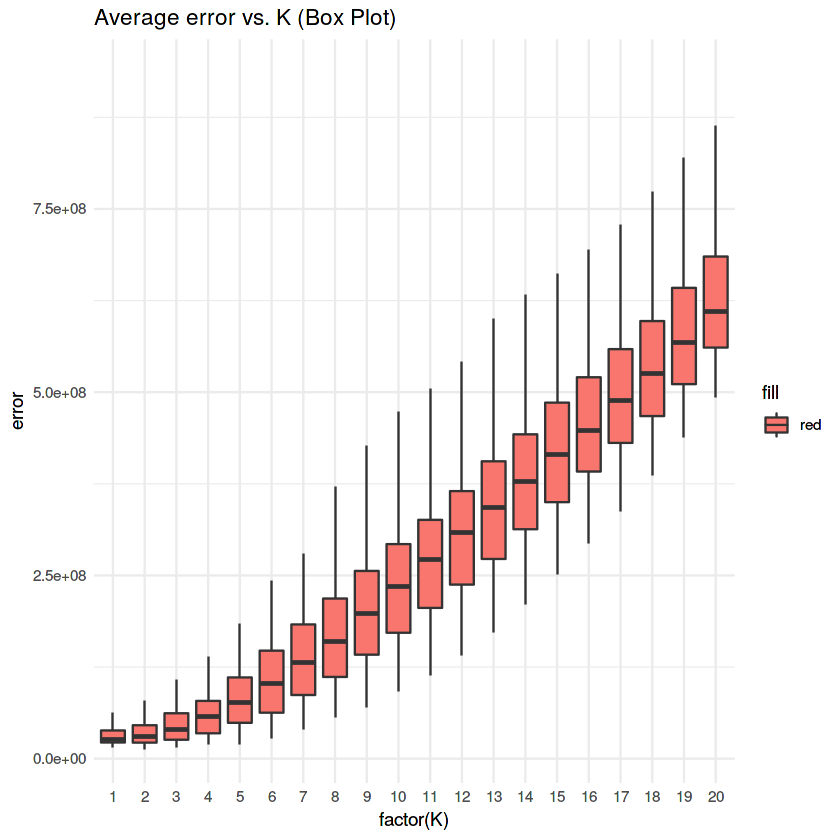

In [14]:
ggplot(data=miss, aes(factor(K), error,fill='red')) + geom_boxplot(outlier.shape=NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Average error vs. K (Box Plot)') + theme_minimal()


###  3. The test error and its uncertainty with respect to K.

1. As the value of K increases the average error increases.
2. The uncertainty of error in the initial is low and in the middle region uncertinity is high. 

In [15]:
# fix the parameters (50,40,50)
K <- 10           # Maximum K for KNN 
L <- 200           # number of datasets
N <- 25          # size of datasets

# generate bootstrap indices:
i = 1
error.value <- data.frame('subset.size'=seq(10,L,10), 'subset.indx'= rep(0,2100),'error'=rep(0,2100))
for(l in seq(from = 10,to = L, by = 10)){
    boot.indx <- boot(nrow(train.data), N, l)
    for(row in 1: l){
        error.value[i, 'subset.size'] <- l
        error.value[i, 'subset.indx'] <- row
        b.indx <- boot.indx[row, ]
        error.value[i, 'error'] <-  sum( ( knn(train.data[b.indx, ], train.label[b.indx], test.data, K)  - test.label ) ^ 2 )
        i = i+1
    }
    
}

### 4. DataSize VS Average error (and the uncertainty around it) 

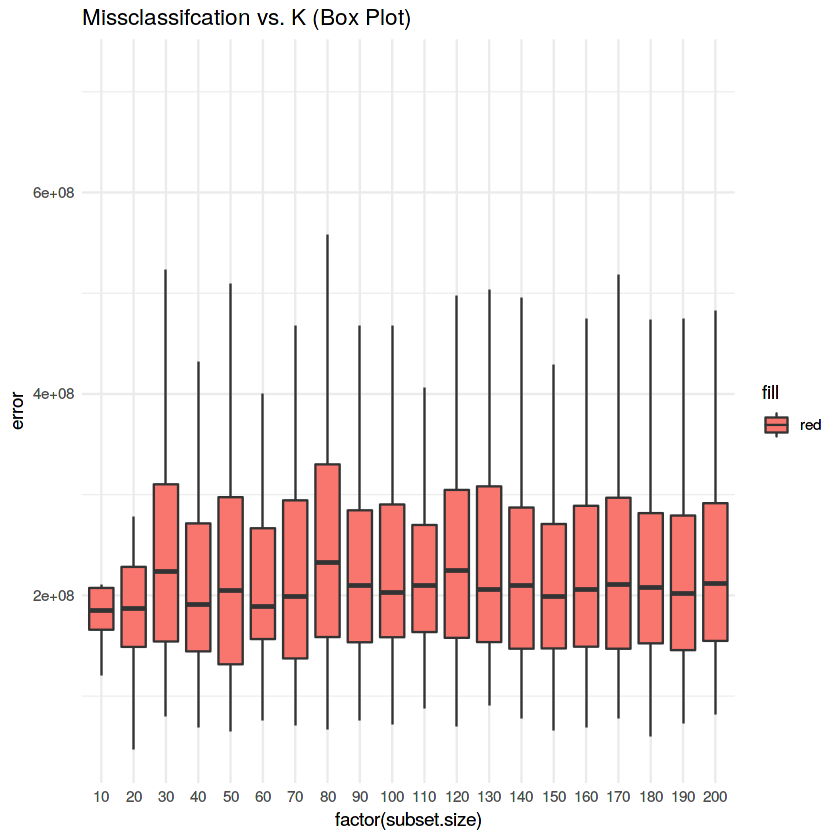

In [16]:
ggplot(data=error.value, aes(factor(subset.size), error,fill='red')) + geom_boxplot(outlier.shape=NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. K (Box Plot)') + theme_minimal()

###  5.The test error and its uncertainty as the number of subsets in bootstrapping increases.

1. When the size of the training data is increasing the average error is more smooth (Constant) as compared to the smaller training data.
2. Average error is becoming stable but still the overall fluctuation is present.